#Linear Regression for MNIST Images

In [1]:
import torch
import torchvision

n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
learning_rate = 1e-2
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [0]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

## Check DataLoader

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


## Also, make sure to display some images

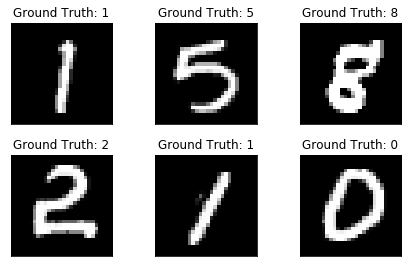

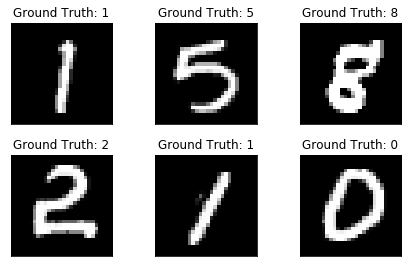

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# Linear regression
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(28*28, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [0]:
linear_model = LinearRegression().to(device)
optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate,amsgrad=True)
classes = torch.tensor([0,1,2,3,4,5,6,7,8,9]).view(1,10).float().to(device)

In [0]:
def train(epoch):
  linear_model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = linear_model(data)
    loss = F.mse_loss(output, target.float().view_as(output)) # notice the use of view_as
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))


In [0]:
def validation():
  linear_model.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad(): # notice the use of no_grad
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = linear_model(data)
      validation_loss += F.mse_loss(output, target.float().view_as(output), size_average=False).item()
      _, pred = torch.min(torch.abs(output - classes),dim=1) # notice the type of broadcasting the subtraction uses here
      correct += pred.eq(target.data.view_as(pred)).sum()
  validation_loss /= len(validation_loader.dataset)
  print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(validation_loss, correct, len(validation_loader.dataset),100. * correct / len(validation_loader.dataset)))

In [0]:
def test():
  linear_model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = linear_model(data)
      test_loss += F.mse_loss(output, target.float().view_as(output), size_average=False).item()
      _, pred = torch.min(torch.abs(output - classes),dim=1) # notice the type of broadcasting the subtraction uses here
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [11]:
validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Avg. loss: 29.0208, Accuracy: 547/5000 (10%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 30.698324
Train Epoch: 1 [12800/55000 (23%)]	Loss: 3.741637
Train Epoch: 1 [25600/55000 (47%)]	Loss: 3.337353
Train Epoch: 1 [38400/55000 (70%)]	Loss: 3.285566
Train Epoch: 1 [51200/55000 (93%)]	Loss: 3.167893

Validation set: Avg. loss: 3.6006, Accuracy: 1064/5000 (21%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 4.077815
Train Epoch: 2 [12800/55000 (23%)]	Loss: 3.522669
Train Epoch: 2 [25600/55000 (47%)]	Loss: 3.994341
Train Epoch: 2 [38400/55000 (70%)]	Loss: 3.135341
Train Epoch: 2 [51200/55000 (93%)]	Loss: 3.566525

Validation set: Avg. loss: 4.5936, Accuracy: 958/5000 (19%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 5.443110
Train Epoch: 3 [12800/55000 (23%)]	Loss: 3.595252
Train Epoch: 3 [25600/55000 (47%)]	Loss: 2.761811
Train Epoch: 3 [38400/55000 (70%)]	Loss: 2.721615
Train Epoch: 3 [51200/55000 (93%)]	Loss: 4.386114

Validation set: Avg. loss: 3.6025, Accuracy: 1078/5000 (21%)

Train Epoch: 